In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import rasterio
import numpy as np
from rasterio.plot import show, show_hist
from scipy.stats import linregress, describe, rv_histogram

In [2]:
#load the excel data
df = pd.read_excel('field_observation.xls')
point_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))
point_data.set_crs(epsg=32644, inplace=True)

Plot       X        Y         nnx         nny  canopy density (%)  \
0       0  548171  3057513  273.033333  416.966667                 0.0   
1       1  547415  3052674  247.833333  578.266667                81.0   
2       2  547177  3052725  239.900000  576.566667                46.0   
3       3  546887  3052673  230.233333  578.300000                84.8   
4       4  546619  3052552  221.300000  582.333333                79.0   
..    ...     ...      ...         ...         ...                 ...   
367   367  549780  3065424  326.666667  153.266667                76.0   
368   368  550326  3065855  344.866667  138.900000                81.0   
369   369  549604  3065668  320.800000  145.133333                81.0   
370   370  548628  3065963  288.266667  135.300000                75.1   
371   371  548309  3065676  277.633333  144.866667                86.0   

     light intensity                        geometry  
0              18.40  POINT (548171.000 3057513.000)  
1               2.20  POINT (547415.000 3052674.000)  
2              11.80  POINT (547177.000 3052725.000)  
3               1.90  POINT (546887.000 3052673.000)  
4               2.30  POINT (546619.000 3052552.000)  
..               ...                             ...  
367             4.27  POINT (549780.000 3065424.000)  
368             1.60  POINT (550326.000 3065855.000)  
369             3.60  POINT (549604.000 3065668.000)  
370             2.87  POINT (548628.000 3065963.000)  
371             1.00  POINT (548309.000 3065676.000)  

[372 rows x 8 columns]

In [3]:
!gdal_translate np_20011024_refl.img -b 4 -b 5 -b 3 np_20011024_refl.tif

Input file size is 400, 834
0...10...20...30...40...50...60...70...80...90...100 - done.


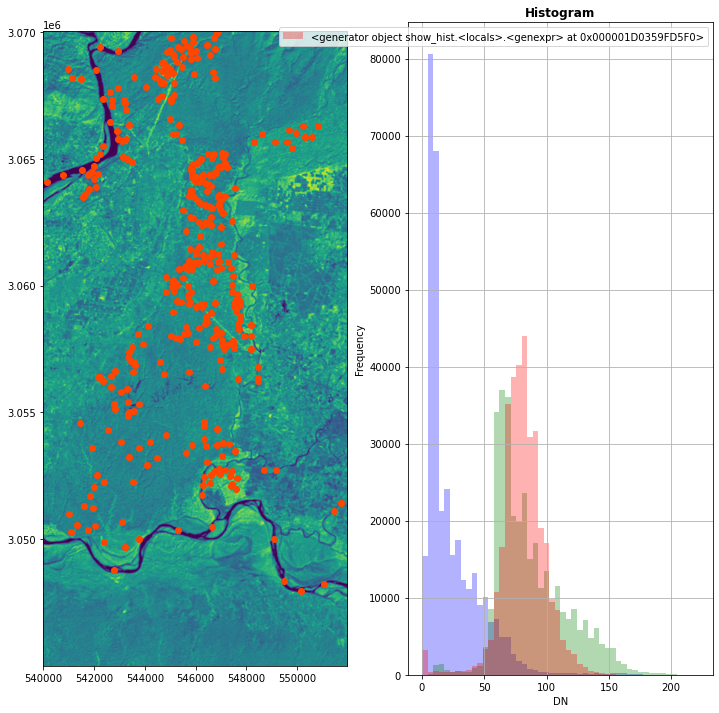

In [4]:
s = rasterio.open('np_20011024_refl.tif')
fig, (ax, axhist) = plt.subplots(1, 2, figsize=(12,12))
point_data.plot(ax=ax, color='orangered')
show(s, ax=ax)
show_hist(s, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

In [5]:
# extract raster values at points using rasterio .sample()
coords = [(x,y) for x, y in zip(point_data.X, point_data.Y)]
point_data['Raster Value'] = [x for x in s.sample(coords)]

In [6]:
# calculate NDVI
point_data['NDVI'] = (point_data['Raster Value'].str[0] - point_data['Raster Value'].str[2]) / (point_data['Raster Value'].str[0] + point_data['Raster Value'].str[2])

In [7]:
# calculate SR
point_data['SR'] = point_data['Raster Value'].str[0]/point_data['Raster Value'].str[2]

In [8]:
point_data.head()

Plot       X        Y         nnx         nny  canopy density (%)  \
0     0  548171  3057513  273.033333  416.966667                 0.0   
1     1  547415  3052674  247.833333  578.266667                81.0   
2     2  547177  3052725  239.900000  576.566667                46.0   
3     3  546887  3052673  230.233333  578.300000                84.8   
4     4  546619  3052552  221.300000  582.333333                79.0   

   light intensity                        geometry    Raster Value      NDVI  \
0             18.4  POINT (548171.000 3057513.000)  [145, 152, 38]  0.584699   
1              2.2  POINT (547415.000 3052674.000)    [128, 90, 3]  0.954198   
2             11.8  POINT (547177.000 3052725.000)     [93, 76, 5]  0.897959   
3              1.9  POINT (546887.000 3052673.000)    [132, 88, 8]  0.885714   
4              2.3  POINT (546619.000 3052552.000)    [117, 82, 8]  0.872000   

          SR  
0   3.815789  
1  42.666667  
2  18.600000  
3  16.500000  
4  14.625000

In [9]:
#calculate correlation coefficients
#clean this UP #########################################################
canopy_band4 = point_data['canopy density (%)'].corr(point_data['Raster Value'].str[0])
canopy_band5 = point_data['canopy density (%)'].corr(point_data['Raster Value'].str[1])
canopy_band3 = point_data['canopy density (%)'].corr(point_data['Raster Value'].str[2])
canopy_NDVI = point_data['canopy density (%)'].corr(point_data['NDVI'])
canopy_SR = point_data['canopy density (%)'].corr(point_data['SR'])

light_band4 = point_data['light intensity'].corr(point_data['Raster Value'].str[0])
light_band5 = point_data['light intensity'].corr(point_data['Raster Value'].str[1])
light_band3 = point_data['light intensity'].corr(point_data['Raster Value'].str[2])
light_NDVI = point_data['light intensity'].corr(point_data['NDVI'])
light_SR = point_data['light intensity'].corr(point_data['SR'])

In [10]:
corr_dict = {'biological attributes': ['canopy density (%)', 'light intensity'],
            'Band 4': [canopy_band4, light_band4],
            'Band 5': [canopy_band5, light_band5],
            'Band 3': [canopy_band3, light_band3],
            'NDVI': [canopy_NDVI, light_NDVI],
            'SR': [canopy_SR, light_SR]}

corr_df = pd.DataFrame(corr_dict)

In [11]:
corr_df = corr_df.transpose()
corr_df

0                1
biological attributes  canopy density (%)  light intensity
Band 4                           0.320603        -0.323536
Band 5                          -0.216024         0.206974
Band 3                           -0.53462         0.525831
NDVI                              0.53777        -0.533861
SR                                    NaN              NaN

In [12]:
# calculate the correlation between canopy attributes
point_data['canopy density (%)'].corr(point_data['light intensity'])

-0.9886624290330429

In [13]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=point_data['NDVI'], y=point_data['canopy density (%)'], mode='markers', name='NDVI'))
# fig.add_trace(
#     go.Scatter(x=point_data['SR'], y=point_data['canopy density (%)'], mode='markers', name='SR'))
fig.show()

In [14]:
# remove ) valies and outlier in NDVI
point_data_new = point_data[(point_data['canopy density (%)'] > 0.0) & (point_data['NDVI'] > 0.5)].copy()

In [15]:
point_data_new.head()

Plot       X        Y         nnx         nny  canopy density (%)  \
1     1  547415  3052674  247.833333  578.266667                81.0   
2     2  547177  3052725  239.900000  576.566667                46.0   
3     3  546887  3052673  230.233333  578.300000                84.8   
4     4  546619  3052552  221.300000  582.333333                79.0   
5     5  546573  3052201  219.766667  594.033333                47.6   

   light intensity                        geometry  Raster Value      NDVI  \
1              2.2  POINT (547415.000 3052674.000)  [128, 90, 3]  0.954198   
2             11.8  POINT (547177.000 3052725.000)   [93, 76, 5]  0.897959   
3              1.9  POINT (546887.000 3052673.000)  [132, 88, 8]  0.885714   
4              2.3  POINT (546619.000 3052552.000)  [117, 82, 8]  0.872000   
5             10.0  POINT (546573.000 3052201.000)  [111, 88, 8]  0.865546   

          SR  
1  42.666667  
2  18.600000  
3  16.500000  
4  14.625000  
5  13.875000

In [16]:
point_data_new['SR'].describe()

count    258.000000
mean            inf
std             NaN
min        3.076923
25%        7.643939
50%        9.708333
75%       13.364583
max             inf
Name: SR, dtype: float64

In [17]:
point_data_new['SR'].replace(np.inf, np.nan, inplace=True)

In [18]:
#calculate correlation coefficients
canopy_band4 = point_data_new['canopy density (%)'].corr(point_data_new['Raster Value'].str[0])
canopy_band5 = point_data_new['canopy density (%)'].corr(point_data_new['Raster Value'].str[1])
canopy_band3 = point_data_new['canopy density (%)'].corr(point_data_new['Raster Value'].str[2])
canopy_NDVI = point_data_new['canopy density (%)'].corr(point_data_new['NDVI'])
canopy_SR = point_data_new['canopy density (%)'].corr(point_data_new['SR'])

light_band4 = point_data_new['light intensity'].corr(point_data_new['Raster Value'].str[0])
light_band5 = point_data_new['light intensity'].corr(point_data_new['Raster Value'].str[1])
light_band3 = point_data_new['light intensity'].corr(point_data_new['Raster Value'].str[2])
light_NDVI = point_data_new['light intensity'].corr(point_data_new['NDVI'])
light_SR = point_data_new['light intensity'].corr(point_data_new['SR'])

In [19]:
corr_dict = {'biological attributes': ['canopy density (%)', 'light intensity'],
            'Band 4': [canopy_band4, light_band4],
            'Band 5': [canopy_band5, light_band5],
            'Band 3': [canopy_band3, light_band3],
            'NDVI': [canopy_NDVI, light_NDVI],
            'SR': [canopy_SR, light_SR]}

corr_df = pd.DataFrame(corr_dict)

In [20]:
corr_df = corr_df.transpose()
corr_df

0                1
biological attributes  canopy density (%)  light intensity
Band 4                           0.326074         -0.30899
Band 5                          -0.282964         0.286562
Band 3                          -0.560606         0.533888
NDVI                             0.617229        -0.588258
SR                               0.458158        -0.431034

In [21]:
fig2 = go.Figure()
fig2.add_trace(
    go.Scatter(x=point_data_new['NDVI'], y=point_data_new['canopy density (%)'], mode='markers', name='NDVI'))
# fig2.add_trace(
#     go.Scatter(x=point_data_new['SR'], y=point_data_new['canopy density (%)'], mode='markers', name='SR'))
fig2.show()

In [22]:
#Set bands for generating raster
red = s.read(3).astype(float)
nir = s.read(1).astype(float)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [23]:
# calculate SR for raster
SR = nir/red

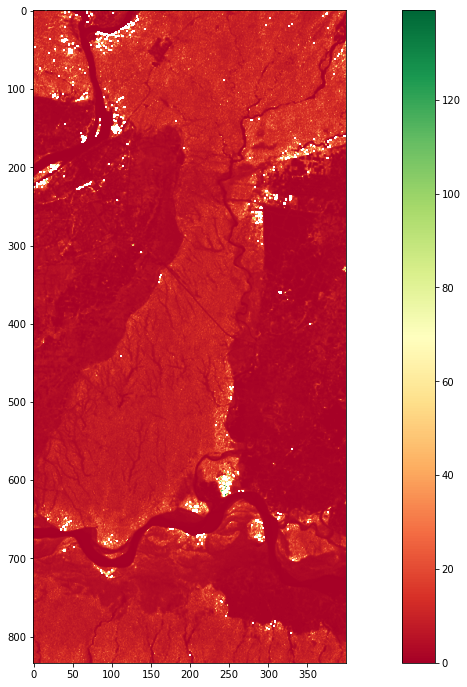

In [24]:
plt.figure(figsize = (20,12))
plt.imshow(SR, cmap="RdYlGn")
plt.colorbar()
plt.show()

<AxesSubplot:>

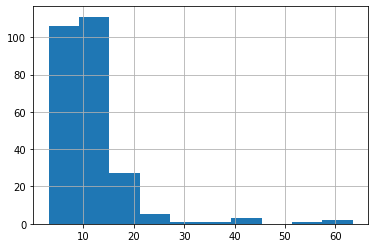

In [25]:
point_data_new['SR'].hist()

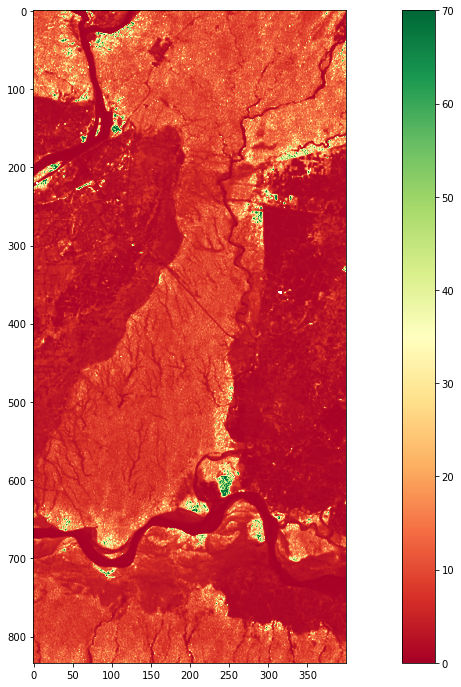

In [26]:
plt.figure(figsize = (20,12))
plt.imshow(np.clip(SR, 0, 70), cmap="RdYlGn")
plt.colorbar()
plt.show()

In [27]:
NDVI = (nir-red)/(nir+red)

(array([[ 12.,   0.,   5., ..., 224., 275., 185.],
        [ 13.,   3.,   2., ..., 219., 271., 193.],
        [ 15.,   0.,   1., ..., 219., 301., 191.],
        ...,
        [  1.,   0.,   3., ..., 153.,  99., 167.],
        [  1.,   1.,   1., ..., 173.,  91., 172.],
        [  1.,   1.,   0., ..., 162.,  92., 180.]]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 400 BarContainer objects>)

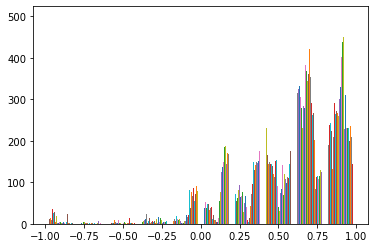

In [28]:
plt.hist(NDVI)

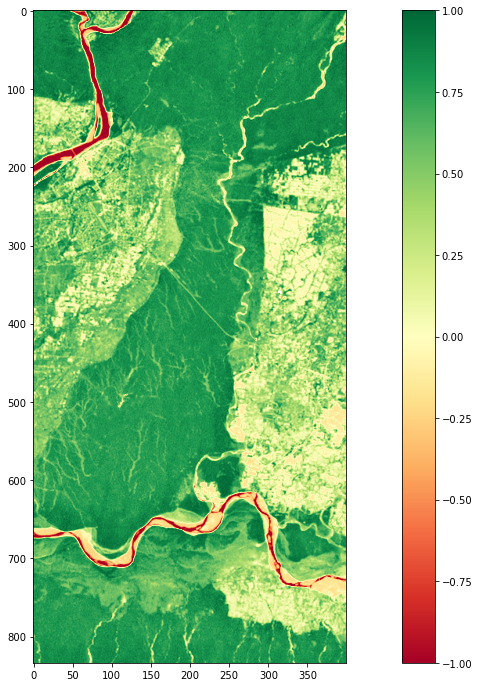

In [29]:
plt.figure(figsize = (20,12))
plt.imshow(NDVI, cmap="RdYlGn")
plt.colorbar()
plt.show()

In [53]:
#s.close()

In [60]:
NDVI_raster = rasterio.open(
    'NDVI_raster.tif',
    'w',
    driver='GTiff',
    height=s.shape[0],
    width=s.shape[1],
    count=1,
    dtype='float64',
    crs='+proj=latlong',
    
)
NDVI_raster.write(NDVI, 1)
NDVI_raster.close()

CPLE_AppDefinedError: Deleting NDVI_raster.tif failed: Permission denied

In [30]:
#calculate regrewssion stats
reg = linregress(point_data_new['NDVI'],point_data_new['canopy density (%)'])
print(reg)

LinregressResult(slope=186.65945760658215, intercept=-103.7461581835557, rvalue=0.6172289374610263, pvalue=1.7507047946226463e-28, stderr=14.870961139036076, intercept_stderr=12.089842416897852)


In [31]:
# regression equation is: 
'''-103.7461581835557 + (186.65945760658215 * NDVI)'''


'-103.7461581835557 + (186.65945760658215 * NDVI)'

In [32]:
point_data_new['est_cd%'] = reg.intercept + (reg.slope * point_data_new['NDVI'])

In [33]:
point_data_new

Plot       X        Y         nnx         nny  canopy density (%)  \
1       1  547415  3052674  247.833333  578.266667                81.0   
2       2  547177  3052725  239.900000  576.566667                46.0   
3       3  546887  3052673  230.233333  578.300000                84.8   
4       4  546619  3052552  221.300000  582.333333                79.0   
5       5  546573  3052201  219.766667  594.033333                47.6   
..    ...     ...      ...         ...         ...                 ...   
366   366  550820  3066315  361.333333  123.566667                84.0   
367   367  549780  3065424  326.666667  153.266667                76.0   
368   368  550326  3065855  344.866667  138.900000                81.0   
369   369  549604  3065668  320.800000  145.133333                81.0   
371   371  548309  3065676  277.633333  144.866667                86.0   

     light intensity                        geometry  Raster Value      NDVI  \
1               2.20  POINT (547415.000 3052674.000)  [128, 90, 3]  0.954198   
2              11.80  POINT (547177.000 3052725.000)   [93, 76, 5]  0.897959   
3               1.90  POINT (546887.000 3052673.000)  [132, 88, 8]  0.885714   
4               2.30  POINT (546619.000 3052552.000)  [117, 82, 8]  0.872000   
5              10.00  POINT (546573.000 3052201.000)  [111, 88, 8]  0.865546   
..               ...                             ...           ...       ...   
366             1.20  POINT (550820.000 3066315.000)   [95, 71, 7]  0.862745   
367             4.27  POINT (549780.000 3065424.000)   [86, 76, 7]  0.849462   
368             1.60  POINT (550326.000 3065855.000)  [117, 91, 9]  0.857143   
369             3.60  POINT (549604.000 3065668.000)   [91, 72, 4]  0.915789   
371             1.00  POINT (548309.000 3065676.000)  [107, 85, 9]  0.844828   

            SR    est_cd%  
1    42.666667  74.364011  
2    18.600000  63.866416  
3    16.500000  61.580790  
4    14.625000  59.020889  
5    13.875000  57.816229  
..         ...        ...  
366  13.571429  57.293374  
367  12.285714  54.814026  
368  13.000000  56.247663  
369  22.750000  67.194608  
371  11.888889  53.948901  

[258 rows x 12 columns]

<AxesSubplot:>

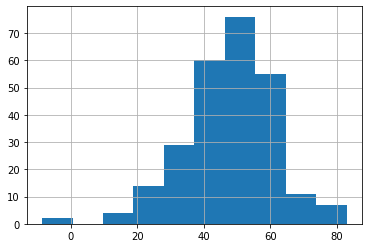

In [34]:
point_data_new['est_cd%'].hist()

In [40]:
point_data_new.loc[point_data_new['est_cd%'] < 0]

Plot       X        Y         nnx    nny  canopy density (%)  \
25     25  542811  3056636   94.366667  446.2                10.0   
165   165  547496  3057551  250.533333  415.7                26.4   

     light intensity                        geometry   Raster Value      NDVI  \
25              16.7  POINT (542811.000 3056636.000)  [84, 100, 25]  0.541284   
165             14.8  POINT (547496.000 3057551.000)   [80, 89, 26]  0.509434   

           SR   est_cd%  
25   3.360000 -2.710305  
165  3.076923 -8.655491

In [35]:
def NDVI2CD(NDVI):
    return reg.intercept + (reg.slope * NDVI)

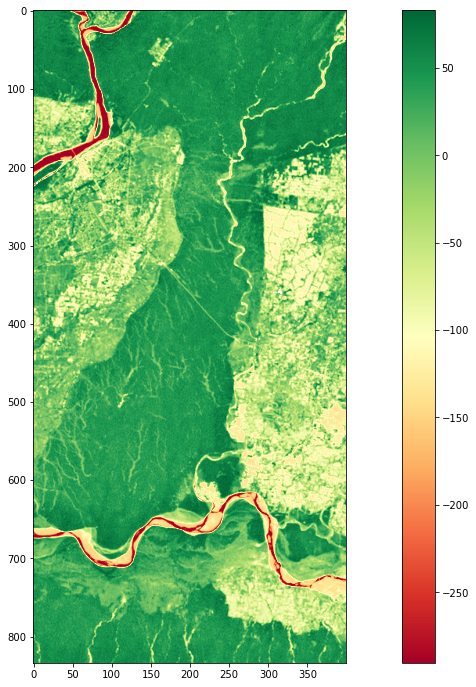

In [36]:
plt.figure(figsize = (20,12))
plt.imshow(NDVI2CD(NDVI), cmap="RdYlGn")
plt.colorbar()
plt.show()

(array([[ 12.,   0.,   5., ..., 227., 278., 185.],
        [ 13.,   3.,   2., ..., 217., 274., 193.],
        [ 15.,   0.,   1., ..., 215., 305., 191.],
        ...,
        [  1.,   0.,   3., ..., 152., 101., 167.],
        [  1.,   1.,   1., ..., 169.,  96., 172.],
        [  1.,   1.,   0., ..., 159.,  95., 180.]]),
 array([-290.40561579, -253.07372427, -215.74183275, -178.40994123,
        -141.0780497 , -103.74615818,  -66.41426666,  -29.08237514,
           8.24951638,   45.5814079 ,   82.91329942]),
 <a list of 400 BarContainer objects>)

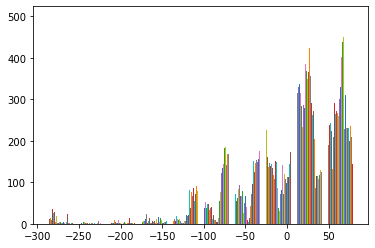

In [37]:
plt.hist(NDVI2CD(NDVI))